# Import data, compute features, train-val split, feature selection, pre-process, & save
## Import
### Modules

In [1]:
from __future__ import division
%matplotlib inline
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Regressor import Regressor
from ML_Tools.General.Feature_Selection import *
from ML_Tools.Transformations.HEP_Proc import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


### Data

In [2]:
def importData(name):
    data = pandas.read_csv(dirLoc + name + '.csv')
    data.rename(index=str, columns={"Weight": "gen_weight", 'PRI_met':'PRI_met_pt'}, inplace=True)
    data['gen_target'] = 0
    if name == 'training':
        data.loc[data.Label == 's', 'gen_target'] = 1
        data.drop(columns=['Label'], inplace=True)        
    return data

In [3]:
trainingData = importData('training')
testingData = importData('test')

In [4]:
trainingData.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,gen_weight,gen_target
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,0


In [5]:
print [x for x in trainingData.columns], len(trainingData.columns)

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_pt', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'gen_weight', 'gen_target'] 33


## Feature processing

In [6]:
rotate = True
cartesian = True
regress = False

In [7]:
def regressData(inData, regressor):
    inData['ll'] = 0
    inData['lh'] = 1
    inData['hh'] = 0
    inData['REG_mass'] = regressor.predict(inData[['ll', 'lh', 'hh']].values.astype('float32'),
                                           inData[['PRI_lep_pt', 'PRI_lep_eta',
                                                   'PRI_tau_pt', 'PRI_tau_phi', 'PRI_tau_eta',
                                                   'PRI_met_pt', 'PRI_met_phi']].values.astype('float32'))
    inData.drop(columns=['ll', 'lh', 'hh'], inplace=True)

In [8]:
def rotateEvent(inData):
    '''Rotate event in phi such that lepton is at phi == 0'''
    inData['PRI_tau_phi'] = deltaphi(inData['PRI_lep_phi'], inData['PRI_tau_phi'])
    inData['PRI_jet_leading_phi'] = deltaphi(inData['PRI_lep_phi'], inData['PRI_jet_leading_phi'])
    inData['PRI_jet_subleading_phi'] = deltaphi(inData['PRI_lep_phi'], inData['PRI_jet_subleading_phi'])
    inData['PRI_met_phi'] = deltaphi(inData['PRI_lep_phi'], inData['PRI_met_phi'])
    inData['PRI_lep_phi'] = 0
    
def convertData(inData, regressor=None):
    '''Pass data through conversions and drop uneeded columns'''
    
    if rotate:
        rotateEvent(inData)
        
    if regress:
        regressData(inData, regressor)
    
    if cartesian:
        moveToCartesian(inData, 'PRI_tau', drop=True)
        moveToCartesian(inData, 'PRI_lep', drop=True)
        moveToCartesian(inData, 'PRI_jet_leading', drop=True)
        moveToCartesian(inData, 'PRI_jet_subleading', drop=True)
        moveToCartesian(inData, 'PRI_met', z=False)
        
        inData.drop(columns=["PRI_met_phi"], inplace=True)
        
    if rotate and not cartesian:
        inData.drop(columns=["PRI_lep_phi"], inplace=True)
    elif rotate and cartesian:
        inData.drop(columns=["PRI_lep_py"], inplace=True)
        
    inData.replace([np.inf, -np.inf], np.nan, inplace=True)
    inData.fillna(-999.0, inplace=True)
    
    for x in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_all_pt']:
        inData.loc[inData[x] < 0, x] = -1

In [9]:
if regress:
    regressor = Regressor()
    regressor.load("/home/giles/cernbox/DiTau_MassRegression/Regressors/weights/HiggsMLRegressor_Direct_modelSwish")
else:
    regressor = None

In [10]:
convertData(trainingData, regressor)
convertData(testingData, regressor)

/home/giles/cernbox/ML_Tools/Transformations/HEP_Proc.py:20: RuntimeWarning: overflow encountered in sinh
  inData[particle + '_pz'] = pt*np.sinh(eta)


In [11]:
trainingData.columns

Index([u'EventId', u'DER_mass_MMC', u'DER_mass_transverse_met_lep',
       u'DER_mass_vis', u'DER_pt_h', u'DER_deltaeta_jet_jet',
       u'DER_mass_jet_jet', u'DER_prodeta_jet_jet', u'DER_deltar_tau_lep',
       u'DER_pt_tot', u'DER_sum_pt', u'DER_pt_ratio_lep_tau',
       u'DER_met_phi_centrality', u'DER_lep_eta_centrality', u'PRI_met_pt',
       u'PRI_met_sumet', u'PRI_jet_num', u'PRI_jet_all_pt', u'gen_weight',
       u'gen_target', u'PRI_tau_px', u'PRI_tau_py', u'PRI_tau_pz',
       u'PRI_lep_px', u'PRI_lep_pz', u'PRI_jet_leading_px',
       u'PRI_jet_leading_py', u'PRI_jet_leading_pz', u'PRI_jet_subleading_px',
       u'PRI_jet_subleading_py', u'PRI_jet_subleading_pz', u'PRI_met_px',
       u'PRI_met_py'],
      dtype='object')

## Regression test

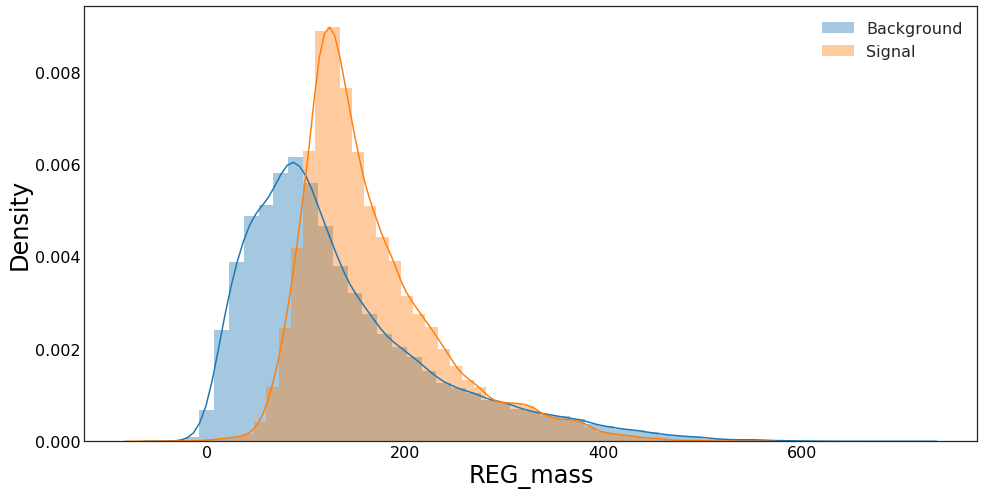

In [30]:
plotFeat(trainingData, 'REG_mass', cuts=[(trainingData.gen_target == 0), (trainingData.gen_target == 1)], labels=['Background', 'Signal'], plotBulk=0, weightName='gen_weight')

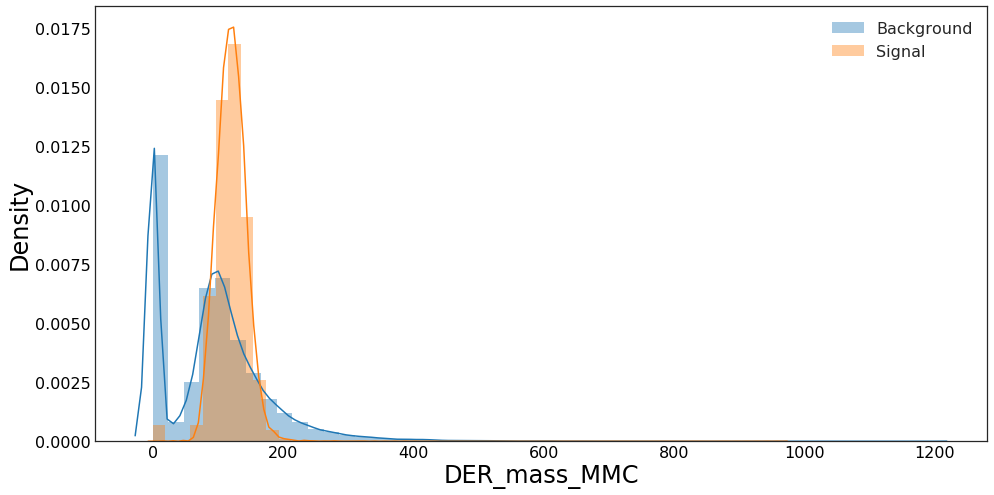

In [31]:
plotFeat(trainingData, 'DER_mass_MMC', cuts=[(trainingData.gen_target == 0), (trainingData.gen_target == 1)], labels=['Background', 'Signal'], plotBulk=0, weightName='gen_weight')

In [13]:
xgCompare([trainingData[['DER_mass_MMC']], trainingData[['REG_mass']]],
          [trainingData[['gen_target']], trainingData[['gen_target']]])

/home/giles/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/giles/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dataset 0, train:test ROC AUC 0.81036:0.80737
Dataset 1, train:test ROC AUC 0.74638:0.74419


In [14]:
trainingData[trainingData.DER_mass_MMC > 0]['DER_mass_MMC'].corr(trainingData[trainingData.DER_mass_MMC > 0]['REG_mass'])

0.6310149291956695

## Train-Validation Split

In [12]:
trainIndeces, valIndeces = splitDevVal(trainingData)
train = trainingData.loc[trainIndeces]
val = trainingData.loc[valIndeces]
print len(train), len(val)

200000 50000


## Feature Selection
### Get important features

In [14]:
trainFeatures = [x for x in train.columns if 'gen' not in x and x != 'EventId']
print len(trainFeatures)

30


%%time
importantFeatures = rankClassifierFeatures(train, trainFeatures)

print importantFeatures[0]

print importantFeatures[0]

In [15]:
importantFeatures = trainFeatures

## Pre-process data

### PCA test

pcaPipe, outputPipe = getPreProcPipes(normIn=True, pca=True, normPCA=True)
pcaFeatures = [x for x in importantFeatures if 'DER' in x]
pcaPipe.fit(train[pcaFeatures].values.astype('float32'))

xgCompare([train[pcaFeatures],
           pcaPipe.transform(train[pcaFeatures].values.astype('float32'))],
          [train['gen_target'],
           train['gen_target']])

In [17]:
classTrainFeatures = importantFeatures

In [18]:
print classTrainFeatures

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


In [19]:
inputPipe, outputPipe = getPreProcPipes(normIn=True)
inputPipe.fit(train[classTrainFeatures].values.astype('float32'))

Pipeline(memory=None,
     steps=[('normIn', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [20]:
with open(dirLoc + 'inputPipe.pkl', 'w') as fout:
    pickle.dump(inputPipe, fout)

In [21]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
        inputPipe = pickle.load(fin)

In [22]:
def saveBatch(inData, n, inputPipe, outFile, normWeights, mode):
    grp = outFile.create_group('fold_' + str(n))
    
    X = inputPipe.transform(inData[classTrainFeatures].values.astype('float32'))
    
    inputs = grp.create_dataset("inputs", shape=X.shape, dtype='float32')
    inputs[...] = X
    
    if mode != 'testing':
        if normWeights:
            inData.loc[inData.gen_target == 0, 'gen_weight'] = inData.loc[inData.gen_target == 0, 'gen_weight']/np.sum(inData.loc[inData.gen_target == 0, 'gen_weight'])
            inData.loc[inData.gen_target == 1, 'gen_weight'] = inData.loc[inData.gen_target == 1, 'gen_weight']/np.sum(inData.loc[inData.gen_target == 1, 'gen_weight'])

        X_weights = inData['gen_weight'].values.astype('float32')
        y = inData['gen_target'].values.astype('int')

        targets = grp.create_dataset("targets", shape=y.shape, dtype='int')
        targets[...] = y

        weights = grp.create_dataset("weights", shape=X_weights.shape, dtype='float32')
        weights[...] = X_weights
    
    else:
        X_EventId = inData['EventId'].values.astype('int')
        
        EventId = grp.create_dataset("EventId", shape=X_EventId.shape, dtype='int')
        EventId[...] = X_EventId

In [23]:
def prepareSample(inData, mode, inputPipe, normWeights, N=10):
    print "Running", mode
    os.system('rm ' + dirLoc + mode + '.hdf5')
    outFile = h5py.File(dirLoc + mode + '.hdf5', "w")
            
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])

    for i, (train, test) in enumerate(folds):
        print "Saving fold:", i, "of", len(test), "events"
        saveBatch(inData.iloc[test], i, inputPipe, outFile, normWeights, mode)

In [24]:
prepareSample(train, 'train', inputPipe, True)
prepareSample(val, 'val', inputPipe, False)
prepareSample(testingData, 'testing', inputPipe, False)

Running train
Saving fold: 0 of 20001 events


/home/giles/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Saving fold: 1 of 20001 events
Saving fold: 2 of 20001 events
Saving fold: 3 of 20000 events
Saving fold: 4 of 20000 events
Saving fold: 5 of 20000 events
Saving fold: 6 of 20000 events
Saving fold: 7 of 19999 events
Saving fold: 8 of 19999 events
Saving fold: 9 of 19999 events
Running val
Saving fold: 0 of 5000 events
Saving fold: 1 of 5000 events
Saving fold: 2 of 5000 events
Saving fold: 3 of 5000 events
Saving fold: 4 of 5000 events
Saving fold: 5 of 5000 events
Saving fold: 6 of 5000 events
Saving fold: 7 of 5000 events
Saving fold: 8 of 5000 events
Saving fold: 9 of 5000 events
Running testing
Saving fold: 0 of 55000 events
Saving fold: 1 of 55000 events
Saving fold: 2 of 55000 events
Saving fold: 3 of 55000 events
Saving fold: 4 of 55000 events
Saving fold: 5 of 55000 events
Saving fold: 6 of 55000 events
Saving fold: 7 of 55000 events
Saving fold: 8 of 55000 events
Saving fold: 9 of 55000 events
